In [2]:
""" Debugging for dataset alignment """
import torchaudio as ta
import torchaudio.transforms as T
import torch
import numpy as np
import yaml
# import mir_eval
import gc

import warnings
# from train import RTBWETrain
# from datamodule import *
from utils import *

from tqdm import tqdm
import wandb
from pesq import pesq
from pystoi import stoi
import random
from torch.utils.data import Subset
import soundfile as sf
from datetime import datetime
import sys
import torch.nn.functional as F
import argparse

from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
# from SEANet_v2 import SEANet_ver2
from MelGAN import Discriminator_MelGAN
from MBSTFTD import MultiBandSTFTDiscriminator

from dataset import CustomDataset

# from models.SEANet_TFiLM import SEANet_TFiLM
from models.SEANet import SEANet
from models.SEANet_TFiLM_nok_modified import SEANet_TFiLM 

def load_model(model, checkpoint_path):
    # model = model.to(DEVICE)
    ckpt = torch.load(checkpoint_path)
    model.load_state_dict(ckpt['generator_state_dict'])
    print(f"Model loaded from {checkpoint_path}")
    return model

def count_model_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    params_m = total_params / 1000000
    # print(f"Total {params_m:.2f}M Parameters !")
    return total_params

/home/woongjib/anaconda3/envs/env2/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


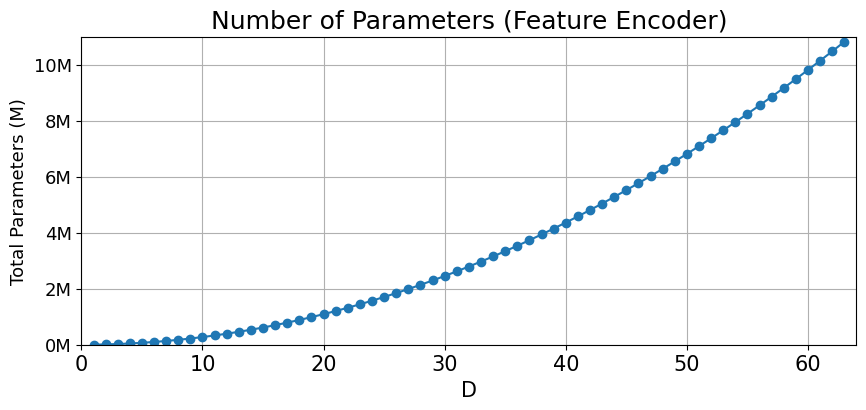

In [3]:
from FeatureExtractor.model_new import ResNet, ResNet18
# Count Parameters
if __name__ == "__main__":
    model = ResNet18(in_channels=4)  

    ######## count parameters for D
    in_channels_list = range(1, 64) 
    params_list = [count_model_parameters(ResNet18(in_channels=in_channels)) for in_channels in in_channels_list]
    # params_list = [count_model_parameters(SEANet(min_dim=in_channels)) for in_channels in in_channels_list]

    plt.figure(figsize=(10,4))
    plt.plot(in_channels_list, params_list, marker='o')
    plt.xlabel('D', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=13)
    plt.ylabel('Total Parameters (M)', fontsize=13) 

    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}M".format(int(x/1000_000))))
    plt.xlim(0, 64)
    plt.ylim(-5, 11000000)
    plt.title('Number of Parameters (Feature Encoder)', fontsize=18)
    plt.grid(True)
    plt.show()

In [8]:
from FeatureExtractor.model_new import ResNet, ResNet18

count_model_parameters(ResNet18(in_channels=64))
count_model_parameters(ResNet18(in_channels=48))
count_model_parameters(ResNet18(in_channels=32))

count_model_parameters(SEANet(min_dim=8))
count_model_parameters(SEANet(min_dim=12))
count_model_parameters(SEANet(min_dim=16))

Total 11.16M Parameters !
Total 6.28M Parameters !
Total 2.79M Parameters !
Total 0.56M Parameters !
Total 1.25M Parameters !
Total 2.22M Parameters !


2224114

In [178]:
from IPython.display import Audio, display
from torchinfo import summary

model = SEANet_TFiLM(visualize=False)

wb_p = [
            "/home/woongjib/Projects/Dataset/FSD50K_WB_SEGMENT/", 
            "/home/woongjib/Projects/Dataset/MUSDB_WB_SEGMENT/", 
            ]
nb_p = [
            "/home/woongjib/Projects/Dataset/FSD50K_LPF/", 
            "/home/woongjib/Projects/Dataset/MUSDB_LPF/", 
            ]

# nb_p = [
#             "/mnt/hdd/Dataset_BESSL_p2/VCTK_HEAAC_zeropad_at_end", 
#             ]

# wb_p = [
#             "//mnt/hdd/Dataset_BESSL_p2/VCTK_WB_SEGMENT_", 
#             ]
dataset = CustomDataset(path_dir_nb=nb_p, path_dir_wb=wb_p, seg_len=0.9, mode="train", high_index=31)

# a = get_audio_paths(nb_p)
# print(a[2])
# b = a
# c = []
# for i in b :
#     newi = i.replace("NB_SEGMENT","WB_SEGMENT")
#     c.append(newi)
# print(c[2])

Index:0 with 283048 samples
Index:1 with 144773 samples
LR 427821 and HR 427821 file numbers loaded!
train: 427821 files loaded


tensor([[4372]])
torch.Size([1, 43200]) torch.Size([1, 43200])


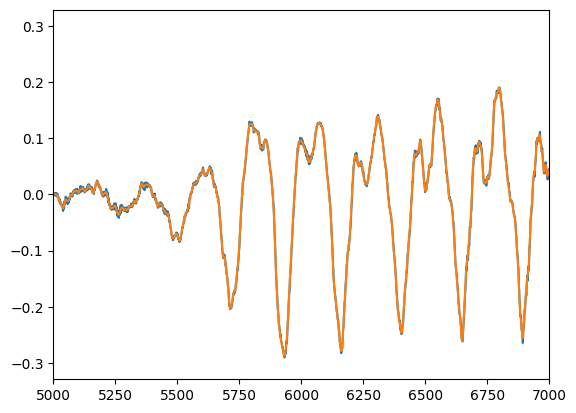

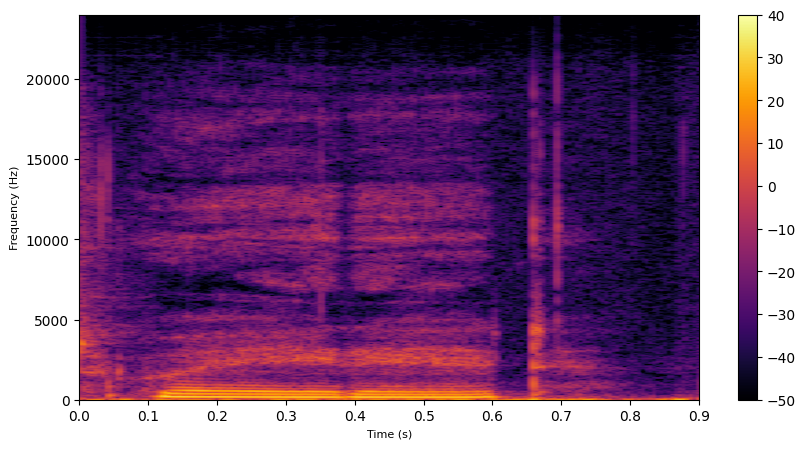

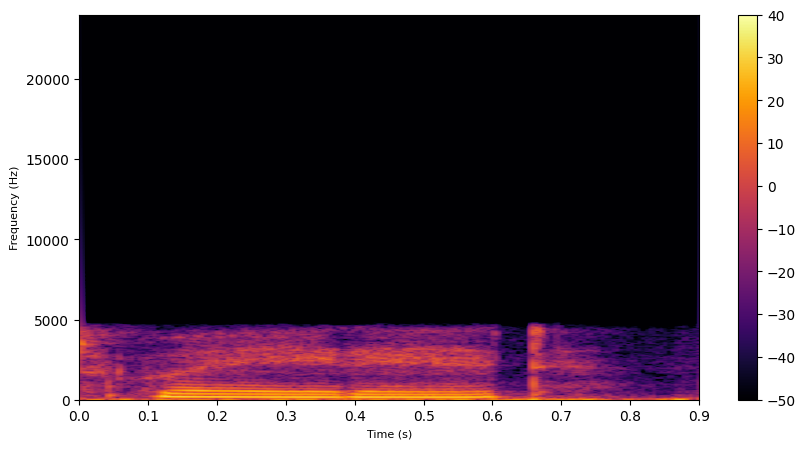

In [184]:
import torchaudio

idx = torch.randint(1,len(dataset),size=(1,1))
print(idx)
# wbp = "/mnt/hdd/Dataset_BESSL/FSD50K_WB_SEGMENT/FSD50K.eval_audio/1471_mono_segment_6.wav"
# nbp = "/mnt/hdd/Dataset_BESSL/FSD50K_NB_SEGMENT/FSD50K.eval_audio/1471_mono_segment_6.wav"
# wb,_ = torchaudio.load(wbp)
# nb,_ = torchaudio.load(nbp)

# wb,_ = torchaudio.load(c[idx])
# nb,_ = torchaudio.load(a[idx])

wb,nb,spec,name,_ = dataset[idx]
print(wb.shape, nb.shape)
# print(spec.shape)    
# print(name)

plt.plot(wb.numpy().squeeze())
plt.plot(nb.numpy().squeeze())
plt.xlim(5000,7000)

draw_spec(wb.numpy().squeeze(), figsize=(10,5), sr=48000)
draw_spec(nb.numpy().squeeze(), figsize=(10,5), sr=48000)
display(Audio(wb.numpy(),rate=48000))
display(Audio(nb.numpy(),rate=48000))




(0.0, 3000.0)

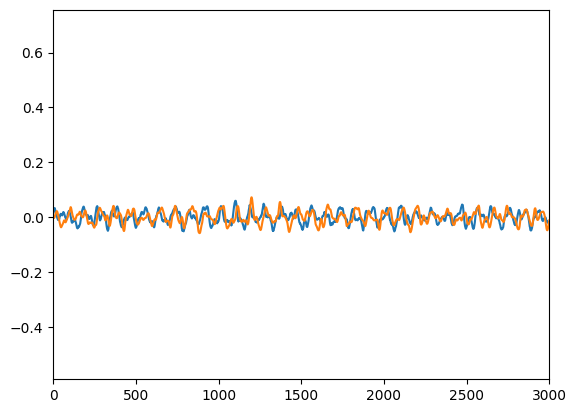

In [102]:
# wb = wb[...,100:]
# nb = nb[...,100:]


In [12]:
enc = model.encoder
count_model_parameters(enc)

Total 1.00M Parameters !


996800